# 1. 必要なファイルのアップロード
  必要なもの
  - 音楽ファイル  
    必須。mp3, ogg, wav などなど  
    大抵のコーデックには対応しているはずですが、もしエラーが出るようなら何かしらに変換してもう一度試してみてください。
    
  - 画像ファイル  
    オプション。  
    1920x1080推奨。それ以外のサイズは適当にリサイズされますが、現在不具合発生中。

# 2. 設定の記入

音楽・画像ファイルのパスは、
1. 左のタブからフォルダーアイコンを選択→
  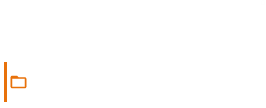

2. ファイルを適当な領域にドラッグアンドドロップでアップロード

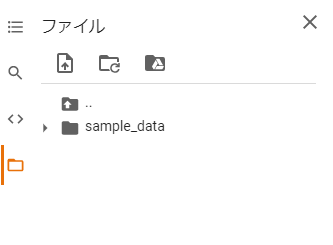
3. 注意はOKをクリックして飛ばす。
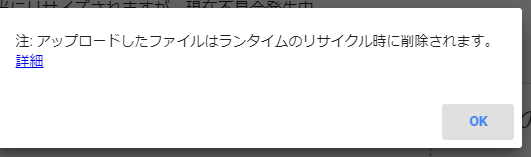
4. アップロードが終わったらファイルを右クリック
5. 右クリックメニューの「パスをコピー」をクリック
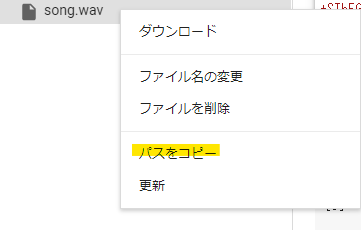
6. ↓の該当部分に貼り付ける。

In [ ]:
#@title #・以下に設定を記入

#@markdown 音楽ファイルのパス。詳細な手順は↑参照。必須
song = "/content/song.wav" #@param {type:"string"}

#@markdown 画像ファイルのパス。詳細な手順は↑参照。オプション
image = "/content/uploadd.png" #@param {type:"string"}

#@markdown ##### フォントのパス。こだわりがなければデフォルト設定で。
#@markdown 好みのフォントを使用する場合は音楽ファイルと同様にアップロードしてパスを入力。
fontpath = "/content/SourceHanSerif-Regular.otf" #@param {type:"string"}

#@markdown FPS(標準:30)
fps = 30.0 #@param {type:"number"}

#@markdown 解像度
size = "1080p" #@param ["1080p","720p","480p"]

#@markdown 楽曲タイトル 不要ならば空白でOK
title = "" #@param {type:"string"}

#@markdown アーティスト名 不要ならば空白でOK
artist = "" #@param {type:"string"}

#@markdown 動画開始秒数
start = 0 #@param {type:"number"}

#@markdown 動画長さ(秒)  *0で楽曲ファイルと同じ秒数
length =  5#@param {type:"number"}

#@markdown フェードイン
fadein = False #@param {type:"boolean"}

#@markdown フェードアウト
fadeout = False  #@param {type:"boolean"}

#@markdown フェードタイム(秒)
fade_time = 4 #@param {type:"number"}

#@markdown 背景色
bgcolor = "black" #@param ["black","white"]

#@markdown 波形色
color = "white" #@param ["white","black"]

#@markdown 文字透過度
transparency = 0 #@param {type:"slider", min:0, max:100, step:1}

#@markdown 波形表示形式
sfig = "line" #@param ["line","rect","None"]

In [ ]:
!pip install pydub
!if [ ! -e /content/SourceHanSerif-Regular.otf ]; then wget https://github.com/adobe-fonts/source-han-serif/raw/release/OTF/Japanese/SourceHanSerif-Regular.otf; fi

In [ ]:
import numpy as np
import librosa,pydub
import cv2 as cv
from PIL import ImageFont, ImageDraw, Image
from pydub import AudioSegment
import subprocess,os
import glob
import copy
from math import ceil
from google.colab import files
from google.colab import output

In [ ]:
if not (os.path.isfile(song)):
    print("invalid input file.")
    exit()
  
#fn = os.path.splitext(os.path.basename(song))[0]
#video = str(fn)+".mp4"
video = "out.mp4"

In [ ]:
#define functions
def sigmoid(x,a):
    return 1.0 / (1.0 + np.exp(-x*a))

def norm(t,start,end,nstart,nend):
    return (t - start) * (nend - nstart) / (end - start) + nstart

def sig(t,start,end,sigrange,a=1): #start,end = timeのstart,end / sigrange = 正規化範囲(+-sigrangeになる)
    nt = norm(t,start,end,-sigrange,sigrange)
    return sigmoid(nt,a)

def puttext_ja(cv_image, text, point, font_path, font_size, color):
    font = ImageFont.truetype(font_path, font_size)

    cv_rgb_image = cv.cvtColor(cv_image, cv.COLOR_BGR2RGB)
    pil_image = Image.fromarray(cv_rgb_image)

    draw = ImageDraw.Draw(pil_image)
    draw.text(point, text, fill=color, font=font)

    cv_rgb_result_image = np.asarray(pil_image)
    cv_bgr_result_image = cv.cvtColor(cv_rgb_result_image, cv.COLOR_RGB2BGR)

    return cv_bgr_result_image

def resize_trim(img, target_width, target_height):
    h,w = img.shape[:2]
    scale_w = float(target_width) / w
    scale_h = float(target_height) / h
    scale = max([scale_w,scale_h])
    x = ceil(scale * w)
    y = ceil(scale * h)
    #img = cv.resize(img,fx=scale,fy=scale,dsize=(0,0))
    imgg = cv.resize(img,dsize=(x,y))
    return imgg[0:target_height,0:target_width]

In [ ]:
#load audio file
try:
    dubclip = AudioSegment.from_file(song,format=song[-3:])
except Exception as e:
    print("unexpected song format.",song[-3:])
    exit()

#check duration >= length
if length != 0 and dubclip.duration_seconds < length:
    print("song is shorter than expected length.")
    exit()

if length == 0:
    print("length not specified. use song duration.")
    length = dubclip.duration_seconds - start
    
    
#clip audio
dubclip = dubclip[start*1000:]
dubclip = dubclip[:length*1000]

#fade audio
if fadein:dubclip = dubclip.fade(from_gain=-np.inf, duration=fade_time*1000, start=0)
if fadeout:dubclip = dubclip.fade(to_gain=-np.inf, duration=fade_time*1000, end=float('inf'))

dubclip.export("tmp.wav",format="wav")

#load spectrums
y,sr = librosa.load("tmp.wav",sr=None,mono=False)
y = librosa.core.to_mono(y) #from stereo to mono for simplicity
y = librosa.util.normalize(y)
spec = librosa.feature.melspectrogram(y=y,sr=sr,hop_length=int(sr*1/fps),power=2.0,norm=1,n_mels=64)
spec = librosa.power_to_db(spec)

#normalize spectrums
spec = norm(spec,np.min(spec),np.max(spec),0,255).astype(np.uint8)
#plt.imshow(spec,origin='lower')

In [ ]:
#draw
drawsize = {"720p":(1280,720),"1080p":(1920,1080),"480p":(640,480)}
#fourcc = cv.VideoWriter_fourcc("X","2","6","4")
writer = cv.VideoWriter("tmp.avi",0,fps,drawsize[size])

bg_bk = lambda: np.zeros((drawsize["1080p"][1],drawsize["1080p"][0],3),dtype=np.uint8)
bg_wh = lambda: np.full((drawsize["1080p"][1],drawsize["1080p"][0],3),255,dtype=np.uint8)

col_bk = (0,0,0)
col_wh = (255,255,255)

if bgcolor == "black":
    bg_ = bg_bk
elif color == "white":
    bg_ = bg_wh

if color == "black":    
    col_ = col_bk
elif color == "white":
    col_ = col_wh

if image:
    img = cv.imread(image)
    if img is None:
        print("image can't be loaded.")
    else:
        img = resize_trim(img,drawsize["1080p"][0],drawsize["1080p"][1])
        bg_ = lambda: copy.deepcopy(img)

for f in range(int(length*fps)):
    output.clear()
    print("rendering: {} / {}".format(f,int(length*fps)))
    #background
    frame = bg_()
    
    #spectrum
    if sfig == "rect":
        #ver.rectangle
        for i,n in enumerate(spec[:,f]):
            for h in range(int(norm(n,0,255,0,24))):
                cv.rectangle(frame, (80+i*28,800-h*20),(80+i*28+14,800-h*20-14),col_, -1, cv.LINE_AA)
                
    elif sfig == "line":
        #ver.line
        for i,n in enumerate(spec[:,f]):
            cv.line(frame,(80+i*28,800),(80+i*28,800-int(2.7*n)),col_,10,cv.LINE_AA)
    
    #text
    #cv.putText(frame,title,(80,980),cv.FONT_HERSHEY_SIMPLEX,4,col_,4,cv.LINE_AA)
    #alter
    ## title
    frame = puttext_ja(frame,title,(80,840),fontpath,130,col_)
    ## artist
    frame = puttext_ja(frame,artist,(100,980),fontpath,70,col_)

    #fadein
    if False:#fadein:
        if f < fade_time*fps:
            alpha = sig(f,0,fade_time*fps,2,2) if f != 0 else 0
            frame = cv.addWeighted(frame,alpha,bg_(),1.0-alpha,0)
    
    #fadeout
    if fadeout:
        if f >= length*fps-1 - fade_time*fps:
            alpha = sig(f,length*fps-1,length*fps-1 - fade_time*fps,2,2) if f != length*fps-1 else 0
            frame = cv.addWeighted(frame,alpha,bg_(),1.0-alpha,0)
        
    #resize
    if size == "1080p":
        pass
    elif size == "720p":
        frame = cv.resize(frame,(1280,720))

    writer.write(frame)
    
    
writer.release()

rendering: 149 / 150


In [ ]:
#save
cmd = "ffmpeg -y -i {} -i {} {} {} -flags global_header {}".format("tmp.avi","tmp.wav","-vcodec h264 -pix_fmt yuv420p -r",fps,video)
#-vcodec copy -acodec copy  
#print(cmd)

#resp = subprocess.call(cmd, shell=True)
!$cmd
os.remove("tmp.avi")
os.remove("tmp.wav")

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
#ファイルのダウンロード
files.download('out.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>